In [1]:
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, freqz, resample,freqs
#fft analysis of the signal and plotting the frequency response graphs
from scipy.fft import fft, fftfreq

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data = pd.read_csv('')
#data = data.set_index('time')

ParserError: ignored

In [ ]:
data['time'] = data.time/10000000

In [ ]:
data_read = data.query('time > 0.75')
data_read1 = data_read.query('time < 1.25')
data_read1 = data

In [ ]:
data_read1 = data_read1.set_index('time')

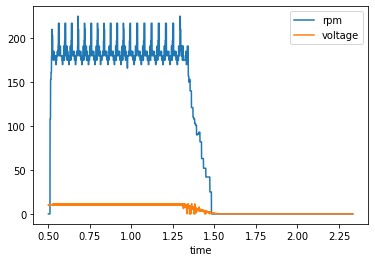

In [ ]:
data_read1.plot()

In [ ]:
u_rpm = data_read1.rpm
u_voltage = data_read1.voltage

In [ ]:
t = np.linspace(0,1,1000)

In [ ]:
re_rpm = resample(u_rpm,1000,t)
re_volt = resample(u_voltage,1000,t)

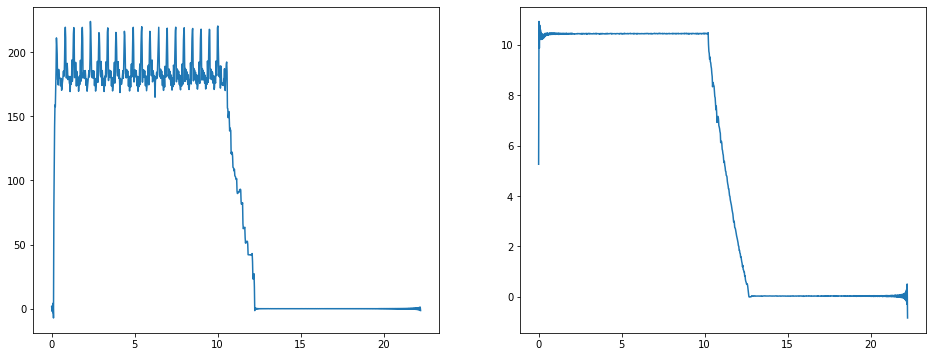

In [ ]:
fig = plt.gcf()
fig.set_size_inches(16, 6)
plt.subplot(1, 2, 1)
plt.plot(re_rpm[1],re_rpm[0])
plt.subplot(1, 2, 2)
plt.plot(re_volt[1],re_volt[0])

plt.show()

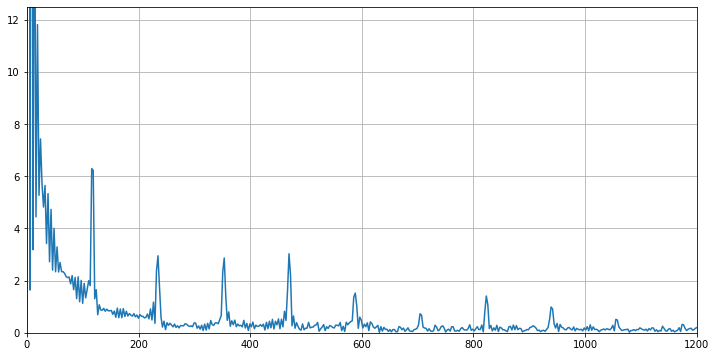

In [ ]:
fig = plt.gcf()
fig.set_size_inches(12, 6)

# Number of sample points
N = len(re_rpm[0])
# sample spacing
T = max(re_rpm[1]) / N

yfrpm = fft(re_rpm[0])
xfrpm = fftfreq(N, T)[:N//2]
xfrpm = 60 *xfrpm

plt.plot(xfrpm, 2.0/N * np.abs(yfrpm[0:N//2]))
plt.xlim([0*60, 20*60])
plt.ylim([0,12.50])
plt.grid()
plt.show()

In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [ ]:
# Filter requirements for rpm.
order = 2
fs = 1000       # sample rate, Hz
cutoff = 200/60  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

fil_rpm = butter_lowpass_filter(re_rpm[0],cutoff,fs,order)

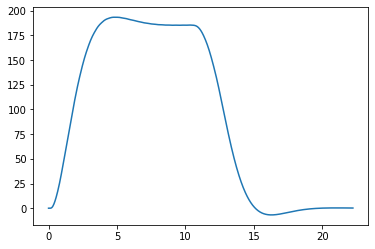

In [ ]:
plt.plot(re_rpm[1],fil_rpm)

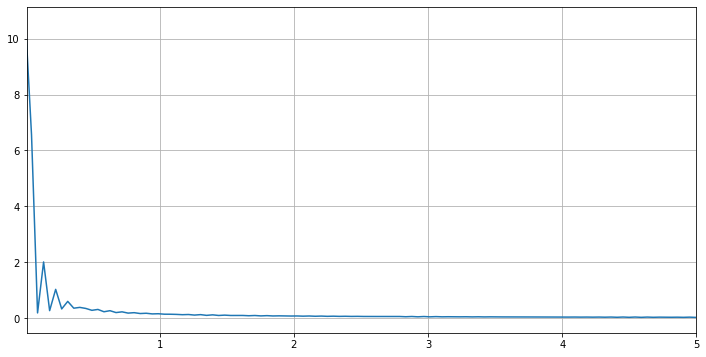

In [ ]:
#for voltage analysis

fig = plt.gcf()
fig.set_size_inches(12, 6)

# Number of sample points
N = len(re_volt[0])
# sample spacing
T = max(re_volt[1]) / N

yf = fft(re_volt[0])
xf = fftfreq(N, T)[:N//2]
#xf = 60 *xf

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim([0.01, 5])
#plt.ylim([0,12.50])
plt.grid()
plt.show()

In [ ]:
# Filter requirements for rpm.
order = 2
fs = 1000       # sample rate, Hz
cutoff = 200/60  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

fil_volt = butter_lowpass_filter(re_volt[0],cutoff,fs,order)

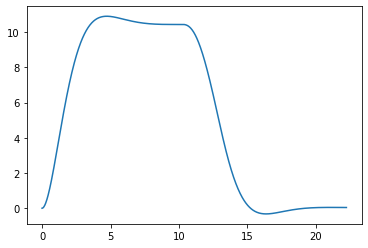

In [ ]:
plt.plot(re_volt[1],fil_volt)

In [ ]:
dataa = pd.DataFrame()
dataa['rpm'] = fil_rpm
dataa['volt'] = fil_volt
dataa['time'] = re_volt[1]
dataa = dataa.set_index('time')

In [ ]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [ ]:
f_data = normalize(dataa)

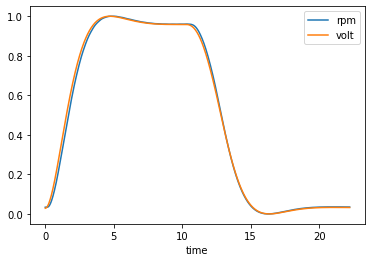

In [ ]:
f_data.plot()

In [ ]:
import numpy as np
from scipy import signal as sig
from scipy import optimize as opt


class TF_identificator:
    def __init__(self):
        self.tf = None
        self.inputs = None

    def first_order_mdl(self, t, k, pole):
        self.tf = sig.TransferFunction(k, [pole, 1])
        to, yo, xo = sig.lsim2(self.tf, U=self.inputs, T=t)
        return yo

    def second_order_mdl(self, t, k, wn, delta):
        self.tf = sig.TransferFunction(k*(wn**2), [1, 2*delta*wn, wn**2])
        to, yo, xo = sig.lsim2(self.tf, U=self.inputs, T=t)
        return yo

    def identify_first_order(self, t, u, orig_output, method='lm', p0=[1.0, 1.0]):
        self.inputs = u
        params, params_cov = opt.curve_fit(self.first_order_mdl, t, orig_output,
                                           method=method, maxfev=1000, p0=p0)
        return {'k': params[0], 'tau': params[1]}

    def identify_second_order(self, t, u, orig_output, method='lm', p0=[1.0, 1.0, 0.1]):
        self.inputs = u
        params, params_cov = opt.curve_fit(self.second_order_mdl, t, orig_output,
                                           method=method, maxfev=1000, p0=p0)
        return {'k': params[0], 'wn': params[1], 'zeta': params[2]}

In [ ]:
t_list = f_data.index
u_list = f_data.volt
y_list = f_data.rpm
tf_ident = TF_identificator()
params =  tf_ident.identify_first_order(t_list, u_list, y_list,                                                      
                                         p0=[200, 0.05])
print("Obtained params:")
print(params)

Obtained params:
{'k': 0.9967710484918626, 'tau': 0.050000085583330085}


In [ ]:
k = params['k']
tau = params['tau']
tf_identify = sig.TransferFunction(k, [tau, 1])

In [ ]:
tf_identify
tf=tf_identify.to_tf()
tf

TransferFunctionContinuous(
array([19.93538685]),
array([ 1.        , 19.99996577]),
dt: None
)

In [ ]:
tout, yout, xout = sig.lsim(tf_identify,np.array(f_data.volt),np.array(f_data.index))

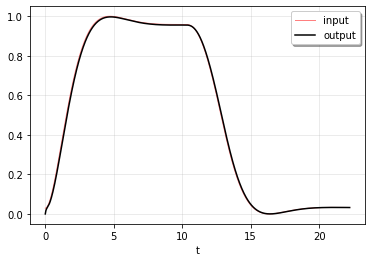

In [ ]:
plt.plot(np.array(f_data.index),np.array(f_data.volt), 'r', alpha=0.5, linewidth=1, label='input')
plt.plot(tout, yout, 'k', linewidth=1.5, label='output')
plt.legend(loc='best', shadow=True, framealpha=1)
plt.grid(alpha=0.3)
plt.xlabel('t')
plt.show()